# TISAFE.
Este CSV contiene datos sobre ciberataques, incluyendo información como la fecha, el país de origen, el tipo de ataque, la industria afectada y una puntuación de riesgo. Estos datos se utilizan para analizar tendencias y patrones en incidentes de ciberseguridad a nivel global


## Importación de librerias.

In [758]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder
import numpy as np
import re
from tabulate import tabulate
from sklearn.cluster import KMeans
import os
from urllib.parse import urlparse
from sklearn.metrics import silhouette_score, silhouette_samples
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import RandomOverSampler
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (
    confusion_matrix,
    classification_report,
    roc_curve,
    auc,
    precision_score,
    recall_score,
)
# === Configuración de colores ===
denexus_colors = ['#1B2D40', '#577596', '#C7262B', '#F85C37', '#FF8250', '#4A4A4A']
denexus_palette = sns.light_palette("#1B2D40", n_colors=100, as_cmap=True)
# Ajustar configuraciones de Pandas
pd.set_option('display.max_columns', None)
pd.set_option('display.width', 1000)

## Importación e información del dataframe

In [652]:
df = pd.read_csv('data/TISAFE.csv', index_col=0) #tomamos la primera columna como índice
df.head()

,date,year,source_database,origin,attack_vector,attack_description,country,industry_type,subcategory,attack_details,ti_safe_score,impact,link_at_the_internet
id,,,,,,,,,,,,,
1338,15/08/2025,2024,TI Safe,External,Ransomware attack,A massive cyberattack disrupted Iran's Central...,Iran,Financial,Banking and Finance,The Central Bank of Iran suffered a major cybe...,4.0,"Severe disruptions in Iran's banking system, w...",<a href='https://www.israelhayom.com/2024/08/1...
1337,15/08/2024,2024,TI Safe,External,Phishing attack,"A previously unknown threat actor, dubbed Acto...",Azerbaijan and Israel,Public Services,"Gpver,emt","In July 2024, a newly identified threat actor,...",4.0,Compromise of sensitive diplomatic data throug...,<a href='https://thehackernews.com/2024/08/new...
1336,15/08/2024,2024,TI Safe,External,Cyberattack,The Iranian state-backed group APT42 launched ...,United States (and Israel),Public Services,Government and Elections,"Between February and late July 2024, APT42, a ...",4.0,Successful breaches of accounts across multipl...,<a href='https://cybersecuritynews.com/iranian...
1335,14/08/2024,2024,TI Safe,External,Ransomware attack,The ThreeAM ransomware targeted Kootenai Healt...,United States,Health and Homecare services,Healthcare,"The ThreeAM ransomware attack, which began on ...",4.0,"Personal and medical data of 464,000 patients ...",<a href='https://securityaffairs.com/167020/da...
1334,14/08/2024,2024,TI Safe,External,Phishing attack,The Brain Cipher ransomware group crippled Ind...,Indonesia,Government,Public Administration,Brain Cipher ransomware group targeted Indones...,4.0,Severe disruptions to government services and ...,<a href='https://www.darkreading.com/threat-in...


In [653]:
df.shape

(1338, 13)

In [654]:
df.dtypes

date                     object
year                      int64
source_database          object
origin                   object
attack_vector            object
attack_description       object
country                  object
industry_type            object
subcategory              object
attack_details           object
ti_safe_score           float64
impact                   object
link_at_the_internet     object
dtype: object

In [655]:
df.columns

Index(['date', 'year', 'source_database', 'origin', 'attack_vector', 'attack_description', 'country', 'industry_type', 'subcategory', 'attack_details', 'ti_safe_score', 'impact', 'link_at_the_internet'], dtype='object')

A continuación, se resume cada columna.

1. **Date**: Fecha exacta en que ocurrió el ciberataque o se registró el incidente.

2. **Year**: Año en que tuvo lugar el ataque, útil para analizar tendencias a lo largo del tiempo.

3. **Source Database**:Fuente o base de datos de la que proviene la información sobre el ciberataque.

4. **Origin**: Origen del ataque, como el país, la región o el actor responsable.

5. **Attack Vector**: Método o vector utilizado para realizar el ataque, como phishing o exploits.

6. **Attack Description**: Descripción resumida del ataque, explicando cómo fue llevado a cabo.

7. **Country**: País o región donde se encontraba el objetivo o donde ocurrió el ataque.

8. **Industry Type**: Tipo de industria o sector afectado, como tecnología, finanzas, gobierno, etc.

9. **Subcategory**: Subdivisión que detalla más el tipo de ataque o la industria afectada.

10. **Attack Details**: Información adicional y técnica sobre cómo se desarrolló el ataque.

11. **TI Safe Score**: Puntaje que refleja el nivel de seguridad o protección del objetivo antes del ataque.

12. **Impact**: Consecuencias del ataque, como pérdidas económicas o robo de información.

13. **Link at the Internet**: Enlace a fuentes externas con más detalles sobre el ataque, como reportes o artículos.


In [656]:
df.describe(include='all')

,date,year,source_database,origin,attack_vector,attack_description,country,industry_type,subcategory,attack_details,ti_safe_score,impact,link_at_the_internet
count,1338,1338.000000,1338,209,196,1338,1338,1337,1338,1305,669.000000,760,1123
unique,965,NaN,5,5,32,1320,113,58,117,762,NaN,708,1051
top,12/05/2017,NaN,CIRWA,External,Malware infection,Hacker attack on Dolomiti Energia,United States,Government facilities sector,Government Facilities,Ransomware Attack - Blocking or encrypting mac...,NaN,Data leakage,<a href='http://www.ibtimes.co.uk/wannacry-lis...
freq,26,NaN,578,172,29,2,679,280,276,543,NaN,11,19
mean,NaN,2017.676383,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3.515695,NaN,NaN
std,NaN,6.294141,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.967345,NaN,NaN
min,NaN,1982.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.000000,NaN,NaN
25%,NaN,2017.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3.000000,NaN,NaN
50%,NaN,2020.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4.000000,NaN,NaN
75%,NaN,2021.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4.000000,NaN,NaN


## Limpieza de datos.

Se nos muestra que tiene un total de 13 columnas que deberemos de examinar para saber cuáles tener en cuenta a la hora de la realización de nuestro estudio y lo que significan cada una de ellas.

**Comprobación fechas**

Si nos damos cuenta, en la primera fila hay una discrepancia entre el año que pone en la columna `Date` y el año que proporciona la columna `Year`. Es por ello, que analizaremos si hay mas casos para evaluar que columna interesa

In [657]:
df['date'] = pd.to_datetime(df['date'], dayfirst=True ,errors='coerce')
df['year_1'] = df['date'].dt.year

df[['date', 'year_1']].head()

,date,year_1
id,,
1338,2025-08-15,2025
1337,2024-08-15,2024
1336,2024-08-15,2024
1335,2024-08-14,2024
1334,2024-08-14,2024


In [658]:
# Filtrar las filas donde year y year_1 son diferentes
diferencias = df[df['year'] != df['year_1']]

print(f"Hay {diferencias.shape[0]} fila donde 'year' y 'year_1' son diferentes.")
diferencias[['year', 'year_1']].head()

Hay 1 fila donde 'year' y 'year_1' son diferentes.


,year,year_1
id,,
1338,2024,2025


In [659]:
df.columns

Index(['date', 'year', 'source_database', 'origin', 'attack_vector', 'attack_description', 'country', 'industry_type', 'subcategory', 'attack_details', 'ti_safe_score', 'impact', 'link_at_the_internet', 'year_1'], dtype='object')

In [660]:
df['date'] = pd.to_datetime(df['date'], dayfirst=True, errors='coerce')
df['day'] = df['date'].dt.day
df['month'] = df['date'].dt.month
# Usaremos la columna year para año (ya dada en el CSV).

cols = ['date', 'day', 'month'] + [col for col in df.columns if col not in ['date', 'day', 'month']] # reorganizar columnas.
df = df[cols]

In [661]:
df.drop(['date', 'year_1'], axis=1, inplace=True)

In [662]:
df.head()

,day,month,year,source_database,origin,attack_vector,attack_description,country,industry_type,subcategory,attack_details,ti_safe_score,impact,link_at_the_internet
id,,,,,,,,,,,,,,
1338,15,8,2024,TI Safe,External,Ransomware attack,A massive cyberattack disrupted Iran's Central...,Iran,Financial,Banking and Finance,The Central Bank of Iran suffered a major cybe...,4.0,"Severe disruptions in Iran's banking system, w...",<a href='https://www.israelhayom.com/2024/08/1...
1337,15,8,2024,TI Safe,External,Phishing attack,"A previously unknown threat actor, dubbed Acto...",Azerbaijan and Israel,Public Services,"Gpver,emt","In July 2024, a newly identified threat actor,...",4.0,Compromise of sensitive diplomatic data throug...,<a href='https://thehackernews.com/2024/08/new...
1336,15,8,2024,TI Safe,External,Cyberattack,The Iranian state-backed group APT42 launched ...,United States (and Israel),Public Services,Government and Elections,"Between February and late July 2024, APT42, a ...",4.0,Successful breaches of accounts across multipl...,<a href='https://cybersecuritynews.com/iranian...
1335,14,8,2024,TI Safe,External,Ransomware attack,The ThreeAM ransomware targeted Kootenai Healt...,United States,Health and Homecare services,Healthcare,"The ThreeAM ransomware attack, which began on ...",4.0,"Personal and medical data of 464,000 patients ...",<a href='https://securityaffairs.com/167020/da...
1334,14,8,2024,TI Safe,External,Phishing attack,The Brain Cipher ransomware group crippled Ind...,Indonesia,Government,Public Administration,Brain Cipher ransomware group targeted Indones...,4.0,Severe disruptions to government services and ...,<a href='https://www.darkreading.com/threat-in...


#### Manejo de filas duplicadas.
En caso de haber filas duplicadas, deberemos de eliminar estas para que no afecten al análisis posterior.

In [663]:
df.duplicated().sum() # Columnas duplicadas

0

In [664]:
df.drop_duplicates(inplace=True)

#### Manejo de filas nulas.

In [665]:
df.isnull().sum() # Valores nulos

day                        0
month                      0
year                       0
source_database            0
origin                  1129
attack_vector           1142
attack_description         0
country                    0
industry_type              1
subcategory                0
attack_details            33
ti_safe_score            669
impact                   578
link_at_the_internet     215
dtype: int64

In [666]:
df.shape[0]

1338

In [667]:
df.drop(['origin', 'attack_vector'], axis = 1, inplace = True)

In [668]:
threshold = 0.4 * len(df.columns)
df = df.dropna(thresh=threshold)

In [669]:
df.dropna(subset=['attack_details', 'industry_type'], inplace=True)

In [670]:
for i in ['link_at_the_internet', 'ti_safe_score', 'impact']:
    if df[i].dtype == 'object':
        df[i].fillna(df[i].mode()[0], inplace=True)
    else:  # Si es una columna numérica
        df[i].fillna(df[i].median(), inplace=True)

## Selección de variables categóricas y continuas.

Para realizar correctamente un ánalisis de datos debemos de distinguir entre las variables categóricas, variables que representan diferentes categorías o grupos, y continuas, variables que pueden tomar cualquier valor dentro de un rango determinado.

In [671]:
v_continuas = []
v_categoricas = []
for i in df.columns:
    if len(df[i].unique()) > 150 or df[i].dtypes == 'float64' or df[i].dtypes == 'int64':
        v_continuas.append(i)
    else:
        v_categoricas.append(i)

print('Variables continuas: {}'.format(', '.join(v_continuas)))
print('Variables categóricas: {}'.format(', '.join(v_categoricas)))

Variables continuas: day, month, year, attack_description, attack_details, ti_safe_score, impact, link_at_the_internet
Variables categóricas: source_database, country, industry_type, subcategory


In [672]:
df.nunique()

day                       31
month                     12
year                      36
source_database            5
attack_description      1286
country                  111
industry_type             56
subcategory              101
attack_details           762
ti_safe_score              6
impact                   677
link_at_the_internet    1018
dtype: int64

#### Tratamiento de variables categóricas.
Para el posterior modelo de clasificación, necesitamos codificar nuestras variables object. Para ello, realizaremos una codificación ordinal que consiste en asignar valores enteros a las categorias basándose en su posición o jerarquía en los datos.

In [673]:
df[v_categoricas].head(3)

,source_database,country,industry_type,subcategory
id,,,,
1338,TI Safe,Iran,Financial,Banking and Finance
1337,TI Safe,Azerbaijan and Israel,Public Services,"Gpver,emt"
1336,TI Safe,United States (and Israel),Public Services,Government and Elections


In [674]:
df[v_categoricas].describe()

,source_database,country,industry_type,subcategory
count,1304,1304,1304,1304
unique,5,111,56,101
top,CIRWA,United States,Government facilities sector,Government Facilities
freq,576,672,280,276


##### **Source Database.**

In [675]:
df['source_database'].unique()

array(['TI Safe', 'CIRWA', 'SCIDMARK', 'SCIDMARK ', 'RISI'], dtype=object)

In [676]:
label_encoder = LabelEncoder()
df['source_database_encoded'] = label_encoder.fit_transform(df['source_database'])

El siguiente código se ha agregado para lograr que las columnas codificadas se agreguen justo después de la columna original, de manera que sea más fácil ver a qué se le ha asignado el valor codificado.

In [677]:
cols = df.columns.tolist()
disclosure_index = cols.index('source_database')
cols.insert(disclosure_index + 1, cols.pop(cols.index('source_database_encoded')))
df = df[cols]

In [678]:
df.head(2)

,day,month,year,source_database,source_database_encoded,attack_description,country,industry_type,subcategory,attack_details,ti_safe_score,impact,link_at_the_internet
id,,,,,,,,,,,,,
1338,15,8,2024,TI Safe,4,A massive cyberattack disrupted Iran's Central...,Iran,Financial,Banking and Finance,The Central Bank of Iran suffered a major cybe...,4.0,"Severe disruptions in Iran's banking system, w...",<a href='https://www.israelhayom.com/2024/08/1...
1337,15,8,2024,TI Safe,4,"A previously unknown threat actor, dubbed Acto...",Azerbaijan and Israel,Public Services,"Gpver,emt","In July 2024, a newly identified threat actor,...",4.0,Compromise of sensitive diplomatic data throug...,<a href='https://thehackernews.com/2024/08/new...


##### **Industry Type.**
Vemos que hay pocos valores únicos, deberemos de examinarlos y catalogarlos por grupos. Tras ello realizaremos una codificación ordinal.

In [679]:
df['industry_type'].unique()

array(['Financial', 'Public Services ', 'Health and Homecare services',
       'Government', 'Tecnology services ', 'Critical Infrastructure',
       'Technology', 'Healthcare',
       'Communication and telecommunications sector', 'Nuclear ',
       'Governemnt ', 'Energy', 'Transport sector and systems', 'Media',
       'Entertainment', 'Government Facilities', 'Business',
       'Healthcare and Public Health', 'Hospital and health sector',
       'Steel and mining', 'Financial Services', 'Energy sector ',
       'Activism', 'Tecnology Services ', 'Country ', 'Food sector ',
       'Manufacturing and automation sector',
       'Water and wastewater sector and systems',
       'Government facilities sector ', 'Commercial and public sector ',
       'Information Technology sector ', 'Education and Research sector ',
       'Sector and Production Systems ', 'Banking and finance sector ',
       'Chemical and Farmaceutic industry sector ',
       'Agricultural sector ', 'Defense and nati

In [680]:
df['industry_type'].nunique()

56

Se observa que hay valores que son el mismo, únicamente con espacios detrás. Para ello deberemos de eliminar estos para que se detecten como el mismo tipo.

In [681]:
df['industry_type'] = df['industry_type'].str.strip()

In [682]:
df['industry_type'].unique()

array(['Financial', 'Public Services', 'Health and Homecare services',
       'Government', 'Tecnology services', 'Critical Infrastructure',
       'Technology', 'Healthcare',
       'Communication and telecommunications sector', 'Nuclear',
       'Governemnt', 'Energy', 'Transport sector and systems', 'Media',
       'Entertainment', 'Government Facilities', 'Business',
       'Healthcare and Public Health', 'Hospital and health sector',
       'Steel and mining', 'Financial Services', 'Energy sector',
       'Activism', 'Tecnology Services', 'Country', 'Food sector',
       'Manufacturing and automation sector',
       'Water and wastewater sector and systems',
       'Government facilities sector', 'Commercial and public sector',
       'Information Technology sector', 'Education and Research sector',
       'Sector and Production Systems', 'Banking and finance sector',
       'Chemical and Farmaceutic industry sector', 'Agricultural sector',
       'Defense and national protection 

In [683]:
df['industry_type'].nunique()

55

Observamos que existe un valor `Information Technology / Government Sites` que combina dos tipos de industria. Si este valor aparece en muchas filas, deberíamos separar los registros en función de cada tipo de industria para analizar si se utilizan de manera individual. En caso contrario, si no se logra una separación clara o no es relevante mantener esta combinación, procederemos a eliminar estas filas.

In [684]:
df[df['industry_type']=='Information Technology / Governement Sites'].shape[0]

1

In [685]:
df = df[df['industry_type'] != 'Information Technology / Governement Sites']

Observamos que hay algunas entradas en la columna que terminan con una palabra, siendo iguales a otras categorías. Para agrupar mejor estos valores, eliminaremos estas palabras de estos registros.

In [686]:
patterns = [r'\s*[sS]ector$', r'\s*[sS]ervices$', r'\s*[fF]acilities$', r'\s*[sS]ystems$']

for pattern in patterns:
    df['industry_type'] = df['industry_type'].str.replace(pattern, '', regex=True)

In [687]:
df['industry_type'].nunique()

45

In [688]:
df['industry_type'].unique()

array(['Financial', 'Public', 'Health and Homecare', 'Government',
       'Tecnology', 'Critical Infrastructure', 'Technology', 'Healthcare',
       'Communication and telecommunications', 'Nuclear', 'Governemnt',
       'Energy', 'Transport sector and', 'Media', 'Entertainment',
       'Business', 'Healthcare and Public Health', 'Hospital and health',
       'Steel and mining', 'Activism', 'Country', 'Food',
       'Manufacturing and automation', 'Water and wastewater sector and',
       'Commercial and public', 'Information Technology',
       'Education and Research', 'Sector and Production',
       'Banking and finance', 'Chemical and Farmaceutic industry',
       'Agricultural', 'Defense and national protection', 'Emergency',
       'Water and Wastewater', 'Transportation', 'Legal', 'Oil and Gas',
       'Apps', 'Agriculture, food and beverage', 'Aerospace', 'Maritime',
       'Engineering', 'Critical Manufacturing', 'Manufacturing',
       'Automotive'], dtype=object)

**Diccionario de Mapeo.**

In [689]:
mappings = {
    'Health and Homecare': [
        'Healthcare', 'Health and Homecare', 'Hospital and health', 'Healthcare and Public Health'
    ],
    'Public': [
        'Public', 'Government', 'Governemnt', 'Education and Research', 'Legal', 'Commercial and public',
        'Activism', 'Country'
    ],
    'Technology': [
        'Technology', 'Tecnology', 'Information Technology', 'Apps', 'Aerospace',
        'Communication and telecommunications'
    ],
    'Energy': [
        'Energy', 'Nuclear', 'Oil and Gas'
    ],
    'Infrastructure': [
        'Critical Infrastructure', 'Water and Wastewater', 'Water and wastewater sector and'
    ],
    'Transport': [
        'Transport sector and', 'Transportation', 'Maritime', 'Automotive'
    ],
    'Manufacturing': [
        'Steel and mining', 'Manufacturing and automation', 'Critical Manufacturing',
        'Sector and Production', 'Manufacturing', 'Engineering'
    ],
    'Agricultural': [
        'Agricultural', 'Food', 'Agriculture, food and beverage'
    ],
    'Business': [
        'Business', 'Entertainment', 'Media'
    ],
    'Defense': [
        'Defense and national protection', 'Emergency'
    ],
    'Chemical Industry': [
        'Chemical and Farmaceutic industry'
    ],
    'Financial': [
        'Financial', 'Banking and finance'
    ]
}

In [690]:
def mapping_indsutry(industry):
    for category, industries in mappings.items():
        if industry in industries:
            return category
    return None

In [691]:
df['industry_type_group'] = df['industry_type'].map(mapping_indsutry)

In [692]:
df['industry_type_group'].isnull().sum()

0

El siguiente código se ha agregado para lograr que las columnas codificadas se agreguen justo después de la columna original, de manera que sea más fácil ver a qué se le ha asignado el valor codificado.

In [693]:
cols = df.columns.tolist()
disclosure_index = cols.index('industry_type')
cols.insert(disclosure_index + 1, cols.pop(cols.index('industry_type_group')))
df = df[cols]

In [694]:
label_encoder = LabelEncoder()
df['industry_type_group_encoded'] = label_encoder.fit_transform(df['industry_type_group'])

El siguiente código se ha agregado para lograr que las columnas codificadas se agreguen justo después de la columna original, de manera que sea más fácil ver a qué se le ha asignado el valor codificado.

In [695]:
cols = df.columns.tolist()
disclosure_index = cols.index('industry_type_group')
cols.insert(disclosure_index + 1, cols.pop(cols.index('industry_type_group_encoded')))
df = df[cols]

In [696]:
df.head(2)

,day,month,year,source_database,source_database_encoded,attack_description,country,industry_type,industry_type_group,industry_type_group_encoded,subcategory,attack_details,ti_safe_score,impact,link_at_the_internet
id,,,,,,,,,,,,,,,
1338,15,8,2024,TI Safe,4,A massive cyberattack disrupted Iran's Central...,Iran,Financial,Financial,5,Banking and Finance,The Central Bank of Iran suffered a major cybe...,4.0,"Severe disruptions in Iran's banking system, w...",<a href='https://www.israelhayom.com/2024/08/1...
1337,15,8,2024,TI Safe,4,"A previously unknown threat actor, dubbed Acto...",Azerbaijan and Israel,Public,Public,9,"Gpver,emt","In July 2024, a newly identified threat actor,...",4.0,Compromise of sensitive diplomatic data throug...,<a href='https://thehackernews.com/2024/08/new...


##### **Countries.**
Para realizar una evaluación más efectiva de los países en nuestros datos, es conveniente agruparlos por continentes. Esto es especialmente relevante porque en otros archivos CSV hay registros de ataques provenientes de diferentes países, distribuidos en distintos continentes.

Para facilitar este análisis, procederemos a crear seis nuevas columnas en nuestro conjunto de datos, cada una representando un continente específico. Estas columnas indicarán con un valor de 1 si el país pertenece al continente correspondiente y 0 si no es así, es decir, mediante una asignación de valores binarios.

In [697]:
df['country'].nunique()

111

In [698]:
df['country'] = df['country'].str.strip()

In [699]:
df['country'].unique()

array(['Iran', 'Azerbaijan and Israel', 'United States (and Israel)',
       'United States', 'Indonesia', 'Global', 'Ukraine', 'United Stats',
       'Russia', 'Not specified', 'France',
       'Multiple countries (global impact)', 'Brazil', 'India',
       'Venezuela', 'United Arab Emirates (Dubai)', 'Italy',
       'European Union', 'Southeast Asian country (unspecified)',
       'Canada', 'Australia', 'United Kingdom',
       'Chile, Spain and Uruguay', 'Spain', 'Morocco and Western Sahara',
       'Germany', 'Israel', 'Mexico', 'Estonia',
       'Not mentioned in the news', 'Switzerland', 'Romania.',
       'Philippines', 'Unknown', 'Sweden', 'Globally', 'Paraguay',
       'Lebanon', 'South Africa', 'Slovenia', 'Denmark', 'Egypt',
       'Finland', 'Asia and United States', 'New Zealand',
       'United States and Canada', 'Colombia', 'Argentina', 'Kenya',
       'Norway', 'Australia and New Zealand', 'Lithuania', 'Japan',
       'Ireland', 'Taiwan', 'Europe', 'Denmark, Sweden, an

In [700]:
continent_mapping = {
    "North America": [
        "United States", "United States and Israel", "Canada", "Mexico", "Puerto Rico", "Guam", 
        "Dominican Republic", "Costa Rica", "Jamaica", "United Stats", "United States (and Israel)"
    ],
    "South America": [
        "Brazil", "Argentina", "Chile", "Venezuela", "Colombia", "Ecuador", "Guyana", "Paraguay", 
        "Uruguay"
    ],
    "Europe": [
        "Ukraine", "France", "Italy", "Spain", "Germany", "Estonia", "Switzerland", "Romania", 
        "Romania.", "Sweden", "Slovenia", "Denmark", "Finland", "Norway", "Ireland", "Portugal", 
        "Greece", "Luxembourg", "Macedonia", "Austria", "Czech Republic", "Netherlands", 
        "United Kingdom", "Lithuania", "Turkey", "Scotland", "Andorra", "Belgium", "Poland", 
        "England", "Netherlands", "Europe", 'European Union', 'Switzerland', '\r\nIceland', 'Finland', 'Azerbaijan'
    ],
    "Asia": [
        "Indonesia", "Russia", "India", "United Arab Emirates", "United Arab Emirates Dubai", 
        "United Arab Emirates (Dubai)", "Southeast Asian country unspecified", "Philippines", 
        "Lebanon", "China", "Taiwan", "Japan", "South Korea", "Singapore", "Pakistan", 
        "Vietnam", "Saudi Arabia", "Qatar", "Malaysia", "Malasya", "Thailand", "Sri Lanka", 
        "Oman", "Arab Emirates", "Iran", "Israel", "Asia", 'Southeast Asian country (unspecified)', 'Cingapore'
    ],
    "Africa": [
        "South Africa", "Egypt", "Morocco", "Western Sahara", "Nigeria", "Kenya", "Chad"
    ],
    "Australia": [
        "Australia", "New Zealand", "South Australia"
    ],
    "Africa, Australia, Asia, Europe, South America, North America": [
        "Global", "Globally", "Multiple countries (global impact)", "Others"
    ]
}

In [701]:
def assign_continent(region):
    continents = set()
    region = region.replace(' and ', ',')
    countries = [country.strip() for country in region.split(',')]

    for country in countries:
        for continent, countries_list in continent_mapping.items():
            if country in countries_list:
                continents.add(continent)
    
    # Devolver una lista de continentes, unirlos como una cadena.
    return ', '.join(continents) if continents else None

# Crear una nueva columna en el DataFrame con los continentes
df['continent'] = df['country'].apply(assign_continent)

In [702]:
countries_with_no_continent = df[df['continent'].isnull()]['country'].unique()

# Mostrar la lista de países con 'continent' como None
print("Lista de países con 'continent' como None:")
print(countries_with_no_continent)

Lista de países con 'continent' como None:
['Not specified' 'Not mentioned in the news' 'Unknown']


In [703]:
df['continent'].isnull().sum()

7

In [704]:
df.dropna(subset=['continent'], inplace=True)

In [705]:
continent_dummies = df['continent'].str.get_dummies(sep=', ')
df = pd.concat([df, continent_dummies], axis=1)

In [706]:
df.drop(columns=['country', 'continent'], inplace=True)

In [707]:
df.head(2)

,day,month,year,source_database,source_database_encoded,attack_description,industry_type,industry_type_group,industry_type_group_encoded,subcategory,attack_details,ti_safe_score,impact,link_at_the_internet,Africa,Asia,Australia,Europe,North America,South America
id,,,,,,,,,,,,,,,,,,,,
1338,15,8,2024,TI Safe,4,A massive cyberattack disrupted Iran's Central...,Financial,Financial,5,Banking and Finance,The Central Bank of Iran suffered a major cybe...,4.0,"Severe disruptions in Iran's banking system, w...",<a href='https://www.israelhayom.com/2024/08/1...,0,1,0,0,0,0
1337,15,8,2024,TI Safe,4,"A previously unknown threat actor, dubbed Acto...",Public,Public,9,"Gpver,emt","In July 2024, a newly identified threat actor,...",4.0,Compromise of sensitive diplomatic data throug...,<a href='https://thehackernews.com/2024/08/new...,0,1,0,1,0,0


##### **Subcategory.**

In [708]:
df['subcategory'].nunique()

98

In [709]:
df['subcategory'].unique()

array(['Banking and Finance', 'Gpver,emt', 'Government and Elections',
       'Healthcare', 'Public Administration', 'Software', 'Policy',
       'Multiple Sectors', 'Global', 'Health and Social Care', 'Russia',
       'Telecommunications', 'Defense/National',
       'Critical Infrastructure', 'Multiple services', 'Aviation',
       'Jornalism ', 'Disney ', 'Public Services', 'Business',
       'Health Services ', 'Hospital Systems ', 'Information Technology',
       'Governmental ', 'Police', 'Companies and Governmental ',
       'Public Sector ', 'Metals Mining', 'Telecommunitacion ',
       'Santander ', 'Industrial Control Systems (ICS)', 'Human Rights',
       'Healthcare services', 'Sewage system', 'Tecnology Services ',
       'Public services', 'Country ', 'Ministries', 'Fintech ', 'Banks ',
       'Public Services ', 'Cryptocurrency', 'National Security ',
       'Electoral systems', 'Healthcare and Public Health', 'Brewery.',
       'Governement sector of Oakley ', 'Federal',

Se observa que hay valores que son el mismo, únicamente con espacios detrás. Para ello deberemos de eliminar estos para que se detecten como el mismo tipo.

In [710]:
df['subcategory'] = df['subcategory'].str.strip()

In [711]:
df['subcategory'].nunique()

96

In [712]:
subcategory_mapping = {
    'Financial': ['Banking and Finance', 'Banks', 'Fintech', 'Financial services', 'Cryptocurrency', 'Financial Services', 'Santander', 'Health insurance industry:'],
    'Government': ['Ministries', 'Policy', 'Gpver,emt', 'Government and Elections', 'Public Administration', 'Governmental', 'Companies and Governmental', 'Public Sector', 'Electoral systems', 'Government', 'Federal', 'Governement sector of Oakley', 'Government Facilities', 'Government Sites', 'Information Technology / Governement Sites'],
    'Healthcare': ['Healthcare and Public Health', 'Hospitality sector','Emergency Services', 'Health and Hospitals', 'Hospital Systems', 'Healthcare', 'Health and Social Care', 'Healthcare services', 'Health Services', 'Hospital Systems', 'Healthcare and Public Health', 'Health and Hospitals', 'Healhtcare Services (NHS Dumfires ang Galloway)', 'Health', 'Healthcare and public health'],
    'Technology': ['Telecommunitacion', 'Telecommunications', 'Software', 'Tecnology Services', 'Information Technology', 'Apps', 'Technology', 'Phones'],
    'Public': ['Public Services', 'Public services', 'Cloud Services for Public Administration.'],
    'Critical Infrastructure': ['Critical Infrastructure', 'Industrial Control Systems (ICS)', 'Water and Wastewater Systems', 'Sewage system'],
    'Nuclear': ['Nuclear Power Plant', 'Nuclear Reactors, Materials, and Waste'],
    'Energy': ['Energy', 'Fuel industry', 'Petrochemical'],
    'Transport': ['Transportation Systems', 'Automotive', 'Aviation', 'Maritime'],
    'Media': ['Jornalism', 'Disney'],
    'Entertainment': ['Entertainment', 'Disney'],
    'Business': ['Business', 'Marketing and services'],
    'Steel and mining': ['Steel and mining', 'Metals Mining', 'Critical Manufacturing'],
    'Activism': ['Human Rights'],
    'Country': ['Country', 'Global', 'Russia'],
    'Water and Wastewater': ['Water and Wastewater Systems', 'Sewage system'],
    'Commercial and public': ['Commercial Facilities', 'Supermarkets'],
    'Information Technology': ['Information Technology', 'Tecnology Services', 'Apps'],
    'Education and Research': ['Education and Research', 'Scientific research and meteorology industry.'],
    'Sector and Production': ['Sector and Production', 'industrial automation industry'],
    'Chemical and Farmaceutic industry': ['Chemical', 'Farmaceutic Industry', 'Pharmaceutical'],
    'Agricultural': ['Agriculture, food and beverage', 'Brewery.', 'Agriculture, food and beverage', 'Brewery.'],
    'Defense and national protection': ['Police', 'Defense/National', 'National Security', 'Security'],
    'Transportation': ['Transportation Systems', 'Aviation', 'Maritime'],
    'Legal': ['Legal'],
    'Oil and Gas': ['Oil and Gas', 'Fuel industry', 'Petrochemical'],
    'Apps': ['Apps'],
    'Aerospace': ['Aerospace'],
    'Engineering': ['Engineering'],
    'Manufacturing': ['Manufacturing', 'industrial automation industry', 'Critical Manufacturing', 'Pulp and Paper', 'Manufacturing', 'industrial automation industry'],
    'Automotive': ['Automotive']
}

In [713]:
def mapping_subcategory(sector):
    for group, sectors in subcategory_mapping.items():
        if sector in sectors:
            return group
    return None

In [714]:
df['subcategory_group'] = df['subcategory'].map(mapping_subcategory)

El siguiente código se ha agregado para lograr que las columnas codificadas se agreguen justo después de la columna original, de manera que sea más fácil ver a qué se le ha asignado el valor codificado.

In [715]:
cols = df.columns.tolist()
disclosure_index = cols.index('subcategory')
cols.insert(disclosure_index + 1, cols.pop(cols.index('subcategory_group')))
df = df[cols]

In [716]:
df['subcategory_group'].isnull().sum()

58

In [717]:
df.dropna(subset=['subcategory_group'], inplace=True)

In [718]:
label_encoder = LabelEncoder()
df['subcategory_group_encoded'] = label_encoder.fit_transform(df['subcategory_group'])

El siguiente código se ha agregado para lograr que las columnas codificadas se agreguen justo después de la columna original, de manera que sea más fácil ver a qué se le ha asignado el valor codificado.

In [719]:
cols = df.columns.tolist()
disclosure_index = cols.index('subcategory_group')
cols.insert(disclosure_index + 1, cols.pop(cols.index('subcategory_group_encoded')))
df = df[cols]

In [720]:
df.head(2)

,day,month,year,source_database,source_database_encoded,attack_description,industry_type,industry_type_group,industry_type_group_encoded,subcategory,subcategory_group,subcategory_group_encoded,attack_details,ti_safe_score,impact,link_at_the_internet,Africa,Asia,Australia,Europe,North America,South America
id,,,,,,,,,,,,,,,,,,,,,,
1338,15,8,2024,TI Safe,4,A massive cyberattack disrupted Iran's Central...,Financial,Financial,5,Banking and Finance,Financial,13,The Central Bank of Iran suffered a major cybe...,4.0,"Severe disruptions in Iran's banking system, w...",<a href='https://www.israelhayom.com/2024/08/1...,0,1,0,0,0,0
1337,15,8,2024,TI Safe,4,"A previously unknown threat actor, dubbed Acto...",Public,Public,9,"Gpver,emt",Government,14,"In July 2024, a newly identified threat actor,...",4.0,Compromise of sensitive diplomatic data throug...,<a href='https://thehackernews.com/2024/08/new...,0,1,0,1,0,0


#### Tratamiento de variables continuas.
Para continuar con nuestro estudio, empezaremos evaluando las variables continuas que en nuestra lista han salido de tipo `object`. Primeramente, evaluamos las variables de tipo objecto.

In [721]:
v_categoricas_cont = list(df[v_continuas].dtypes[df[v_continuas].dtypes == 'object'].index)

In [722]:
df[v_categoricas_cont].nunique()

attack_description      1221
attack_details           727
impact                   645
link_at_the_internet     963
dtype: int64

In [723]:
df[v_categoricas_cont].describe(include='all')

,attack_description,attack_details,impact,link_at_the_internet
count,1238,1238,1238,1238
unique,1221,727,645,963
top,Hacker attack on Dolomiti Energia,Ransomware Attack - Blocking or encrypting mac...,Data leakage,<a href='http://www.ibtimes.co.uk/wannacry-lis...
freq,2,511,553,226


##### **Attack Description, Attack Details e Impact.**
La columna contiene valores que en su mayoría son únicos, lo que sugiere que actúa más como un identificador que como una característica con patrones generales útiles para el modelo. Transformarla directamente podría generar un exceso de categorías o introducir relaciones artificiales entre los valores, lo que podría afectar negativamente el rendimiento del modelo. Por este motivo, es mejor no transformar esta columna y evaluar su relevancia antes de incluirla en el análisis.


In [724]:
df['attack_description'].nunique()

1221

In [725]:
df['attack_details'].nunique()

727

In [726]:
df['impact'].nunique()

645

##### **Link at the internet.**
Deberemos de extraer el nombre del dominio de la URL.

In [727]:
def extract_url(link_html):
    if pd.isna(link_html) or link_html == '':
        return None
    # Usar una expresión regular para encontrar la URL
    match = re.search(r'href=[\'"]?([^\'" >]+)', link_html)
    return match.group(1) if match else None

In [728]:
def obtain_domain(url):
    if pd.isna(url) or url == '':
        return None
    try:
        # Extraer el dominio
        return urlparse(url).netloc
    except Exception as e:
        print(f"Error procesando la URL: {url}, Error: {e}")
        return None

In [729]:
df['link_at_the_internet'] = df['link_at_the_internet'].apply(extract_url)
df['link_at_the_internet'] = df['link_at_the_internet'].apply(obtain_domain)
df['link_at_the_internet'] = df['link_at_the_internet'].str.replace('www.', '', regex=False)

In [730]:
df.head(2)

,day,month,year,source_database,source_database_encoded,attack_description,industry_type,industry_type_group,industry_type_group_encoded,subcategory,subcategory_group,subcategory_group_encoded,attack_details,ti_safe_score,impact,link_at_the_internet,Africa,Asia,Australia,Europe,North America,South America
id,,,,,,,,,,,,,,,,,,,,,,
1338,15,8,2024,TI Safe,4,A massive cyberattack disrupted Iran's Central...,Financial,Financial,5,Banking and Finance,Financial,13,The Central Bank of Iran suffered a major cybe...,4.0,"Severe disruptions in Iran's banking system, w...",israelhayom.com,0,1,0,0,0,0
1337,15,8,2024,TI Safe,4,"A previously unknown threat actor, dubbed Acto...",Public,Public,9,"Gpver,emt",Government,14,"In July 2024, a newly identified threat actor,...",4.0,Compromise of sensitive diplomatic data throug...,thehackernews.com,0,1,0,1,0,0


In [731]:
df.to_csv('data/TISAFE_cleaned.csv')

## Modelos de clasificación.

In [732]:
df_1 = df.drop(list(df.select_dtypes(include=['object']).columns), axis = 1)

In [733]:
df_1.dtypes

day                              int64
month                            int64
year                             int64
source_database_encoded          int32
industry_type_group_encoded      int32
subcategory_group_encoded        int32
ti_safe_score                  float64
Africa                           int64
Asia                             int64
Australia                        int64
Europe                           int64
North America                    int64
South America                    int64
dtype: object

In [734]:
df_1.nunique()

day                            31
month                          12
year                           36
source_database_encoded         5
industry_type_group_encoded    12
subcategory_group_encoded      26
ti_safe_score                   6
Africa                          2
Asia                            2
Australia                       2
Europe                          2
North America                   2
South America                   2
dtype: int64

### Modelos de Clasificación Supervisado.
La columna **TI Safe Score** es valiosa para predecir ciberataques porque representa el nivel de seguridad de un sistema, donde valores más bajos podrían indicar mayor vulnerabilidad. Usarla como variable objetivo permite al modelo identificar qué sistemas tienen mayor probabilidad de ser atacados, clasificándolos como de "alto riesgo" o "bajo riesgo" según su puntaje.

Este enfoque facilita priorizar recursos y estrategias de defensa, enfocándose en los sistemas más críticos. Además, el modelo podría revelar patrones asociados con la vulnerabilidad, como la frecuencia de ataques previos, características técnicas del sistema o la falta de actualizaciones. En resumen, predecir **TI Safe Score** permite anticipar riesgos y fortalecer la ciberseguridad de forma proactiva.

In [735]:
df_1['ti_safe_score'].unique()

array([4., 2., 3., 5., 1., 0.])

In [736]:
df_1['ti_safe_score_binary'] = df_1['ti_safe_score'].apply(lambda x: 1 if x >= 3 else 0) # 1: Alto, 0: Bajo

#### Matriz de correlación.

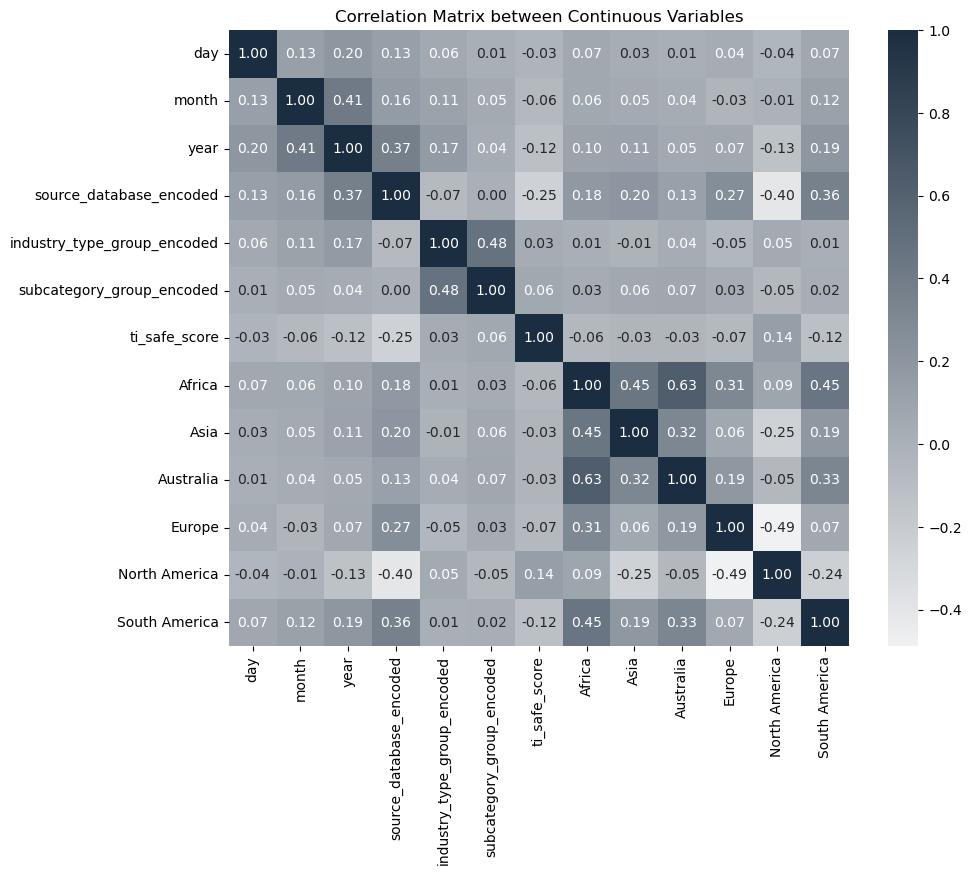

In [737]:
correlation_matrix = df_1.drop(columns=['ti_safe_score_binary'], axis=True).corr()

plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap=denexus_palette, fmt=".2f")
plt.title('Correlation Matrix between Continuous Variables')
plt.show()

##### División en Conjuntos de Entrenamiento y Prueba.

In [738]:
X = df_1.drop(['ti_safe_score_binary', 'ti_safe_score'], axis=1)
y = df_1['ti_safe_score_binary']

In [739]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [740]:
y_train.value_counts()

1    827
0     39
Name: ti_safe_score_binary, dtype: int64

In [741]:
y_test.value_counts()

1    352
0     20
Name: ti_safe_score_binary, dtype: int64

#### Manejo de variables desbalanceadas.
Dado el desbalance de clases en el conjunto de entrenamiento, vamos a aplicar **Random Over-Sampling (ROS)** para equilibrar las clases minoritarias. Esta técnica aumenta la representación de las clases menos frecuentes duplicando aleatoriamente sus instancias, lo que permite que el modelo aprenda de manera más equitativa.

In [742]:
ros = RandomOverSampler(random_state=42)
X_train_ros, y_train_ros = ros.fit_resample(X_train, y_train)

#### Entrenamiento y Evaluación de Modelos.
En este apartado entrenaremos modelos para predecir el nivel de seguridad de los sistemas, representado por **TI Safe Score**. Este puntaje indica vulnerabilidad, donde valores bajos sugieren mayor riesgo de ciberataques. Los modelos permitirán identificar sistemas críticos, priorizar recursos y fortalecer la defensa contra amenazas.

##### **Naive Bayes.**
Naive Bayes es un algoritmo de aprendizaje automático supervisado que se basa en el teorema de Bayes y asume la independencia de las características. Es un modelo de clasificación que se utiliza para predecir la probabilidad de que un dato pertenezca a una clase en particular.

In [743]:
from sklearn.naive_bayes import GaussianNB
nb_model = GaussianNB()
nb_model.fit(X_train_ros, y_train_ros)

GaussianNB()

In [744]:
print("Train set score (Accuracy) =", nb_model.score(X_train_ros, y_train_ros))
print("Test set score (Accuracy) =", nb_model.score(X_test, y_test))

conf_mat = confusion_matrix(y_test, nb_model.predict(X_test))

num_classes = conf_mat.shape[0]

print(tabulate(
    conf_mat,
    headers=[f'Pred Class {i}' for i in range(num_classes)],
    showindex=[f'Real Class {i}' for i in range(num_classes)],
    tablefmt='fancy_grid'
))

print("\nClassification Report:")
print(classification_report(y_test, nb_model.predict(X_test)))

Train set score (Accuracy) = 0.6656590084643289
Test set score (Accuracy) = 0.7338709677419355
╒══════════════╤════════════════╤════════════════╕
│              │   Pred Class 0 │   Pred Class 1 │
╞══════════════╪════════════════╪════════════════╡
│ Real Class 0 │             13 │              7 │
├──────────────┼────────────────┼────────────────┤
│ Real Class 1 │             92 │            260 │
╘══════════════╧════════════════╧════════════════╛

Classification Report:
              precision    recall  f1-score   support

           0       0.12      0.65      0.21        20
           1       0.97      0.74      0.84       352

    accuracy                           0.73       372
   macro avg       0.55      0.69      0.52       372
weighted avg       0.93      0.73      0.81       372



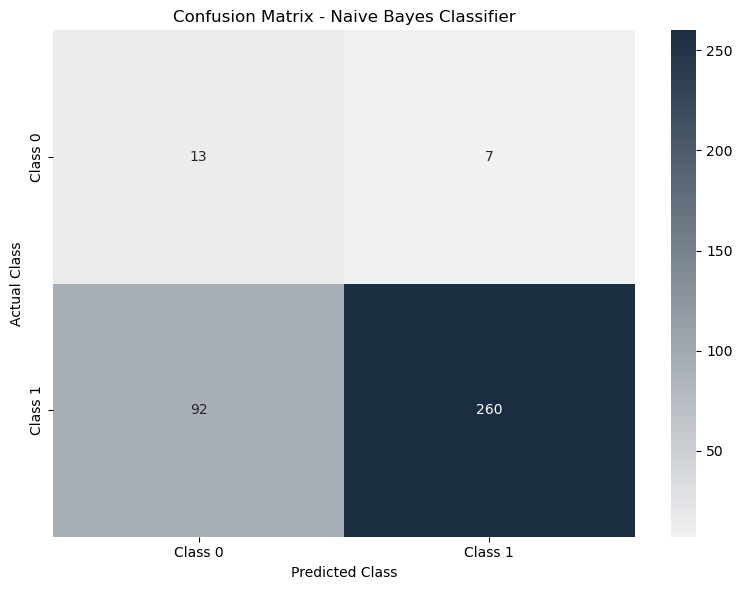

In [745]:
class_labels = [f'Class {i}' for i in range(conf_mat.shape[0])]

plt.figure(figsize=(8, 6))
sns.heatmap(conf_mat, annot=True, fmt='d', cmap=denexus_palette,
            xticklabels=class_labels, yticklabels=class_labels, cbar=True)
plt.title('Confusion Matrix - Naive Bayes Classifier')
plt.xlabel('Predicted Class')
plt.ylabel('Actual Class')
plt.tight_layout()
# Guardar el gráfico en la carpeta 'plots'.
output_dir = "plots"
if os.path.exists(output_dir) and os.path.isdir(output_dir):
    output_path = os.path.join(output_dir, "confusion-matrix_decision-nb.png")
    plt.savefig(output_path)
plt.show()

## Gráficas generales.

### Distribución de ciberataques por año.

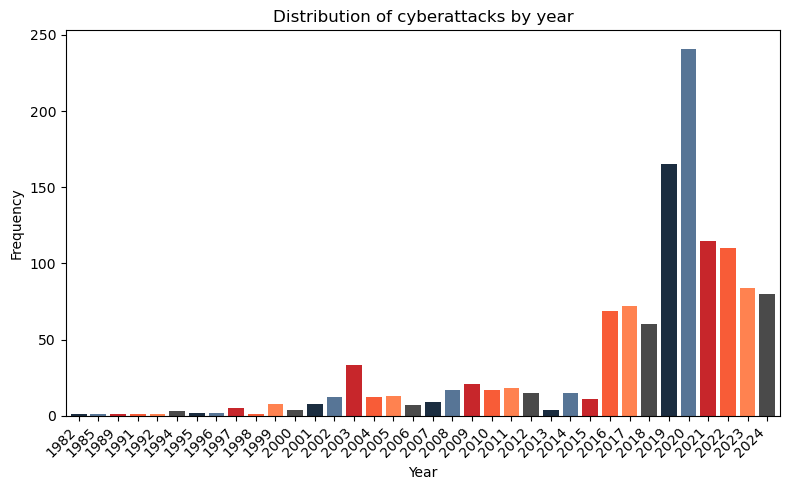

In [760]:
plt.figure(figsize=(8, 5))
df['year'].value_counts().sort_index().plot(kind='bar', color=denexus_colors, width=0.8)
plt.title('Distribution of cyberattacks by year')
plt.xlabel('Year')
plt.ylabel('Frequency')
plt.xticks(rotation=45, ha='right') 
plt.tight_layout()
# Guardar el gráfico en la carpeta 'plots'.
output_dir = "plots"
if os.path.exists(output_dir) and os.path.isdir(output_dir):
    output_path = os.path.join(output_dir, "distribution-attacks-year.png")
    plt.savefig(output_path)
plt.show()

### Histograma de Subcategory.

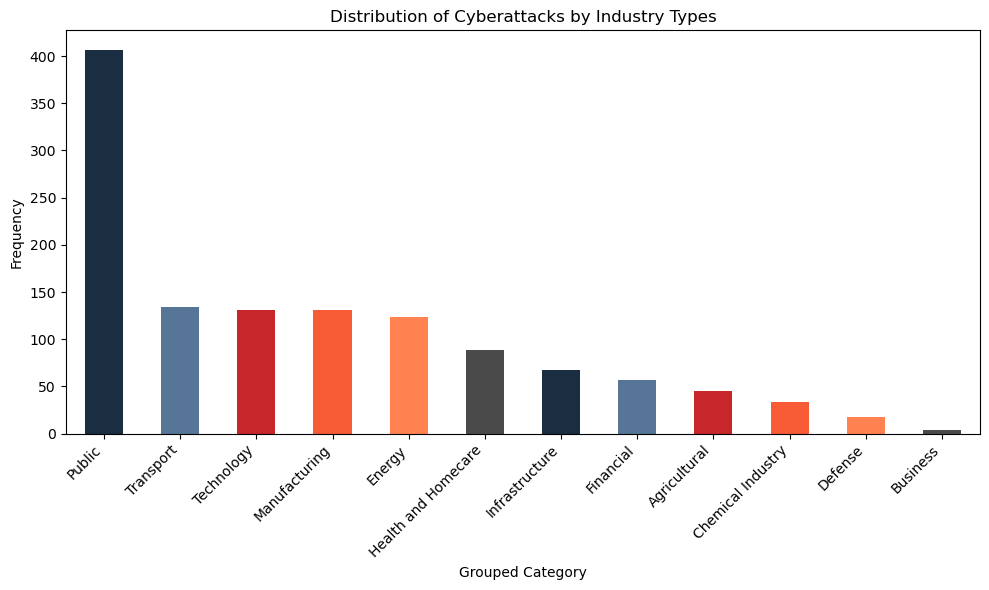

In [762]:
# Histograma 'subcategory'
plt.figure(figsize=(10, 6))
df['industry_type_group'].value_counts().plot(kind='bar', color=denexus_colors)
plt.title('Distribution of Cyberattacks by Industry Types')
plt.xlabel('Grouped Category')
plt.ylabel('Frequency')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
# Guardar el gráfico en la carpeta 'plots'.
output_dir = "plots"
if os.path.exists(output_dir) and os.path.isdir(output_dir):
    output_path = os.path.join(output_dir, "histogram-subcategory.png")
    plt.savefig(output_path)
plt.show()

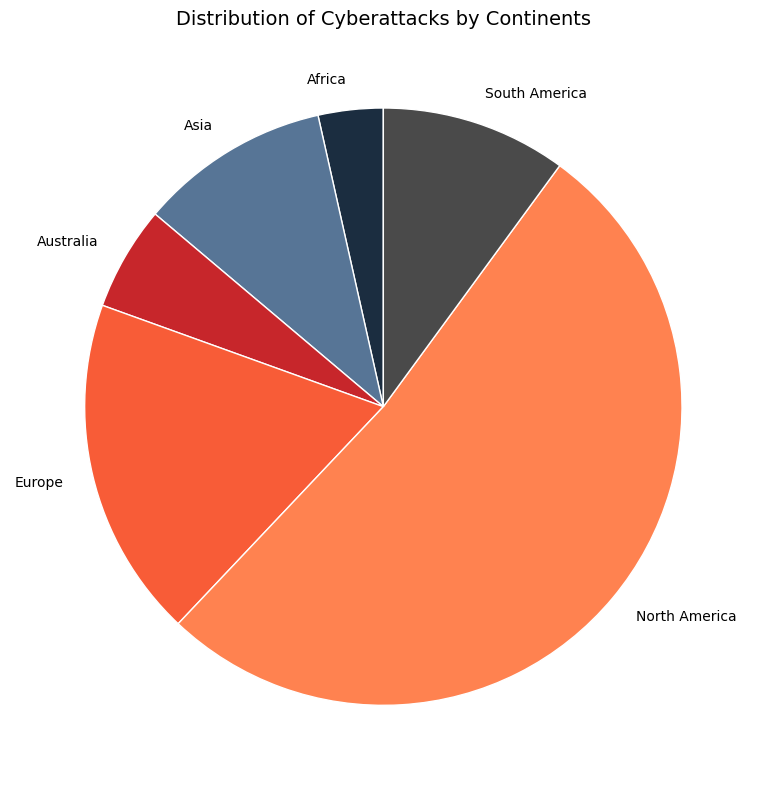

In [763]:
continent_counts = df[['Africa', 'Asia', 'Australia', 'Europe', 'North America', 'South America']].sum()
continent_labels = continent_counts.index

plt.figure(figsize=(8, 8))
plt.pie(
    continent_counts,
    labels=continent_labels,
    colors=denexus_colors[:len(continent_counts)],
    startangle=90,
    wedgeprops={'edgecolor': 'white'},
    textprops={'fontsize': 10}
)
plt.title('Distribution of Cyberattacks by Continents', fontsize=14)
plt.tight_layout()

# Guardar el gráfico en la carpeta 'plots'.
output_dir = "plots"
if os.path.exists(output_dir) and os.path.isdir(output_dir):
    output_path = os.path.join(output_dir, "cyber-attacks-continent.png")
    plt.savefig(output_path)
plt.show()

### Gráficas generales.

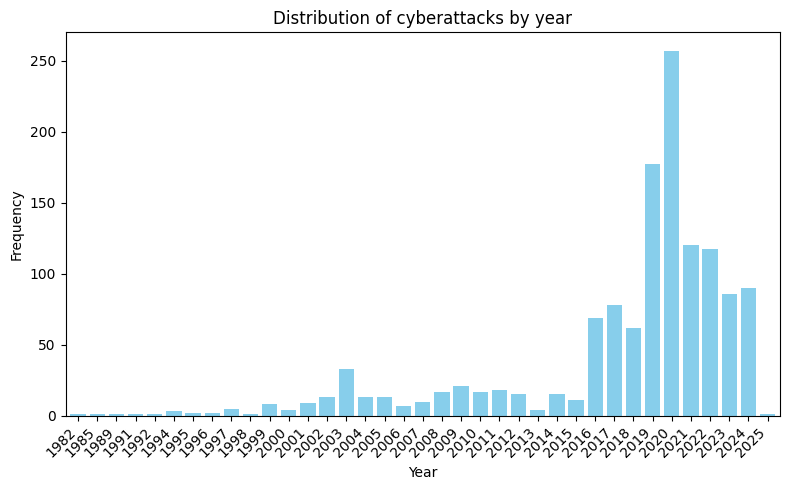

In [ ]:
plt.figure(figsize=(8, 5))
df['year'].value_counts().sort_index().plot(kind='bar', color='skyblue', width=0.8)
plt.title('Distribution of cyberattacks by year')
plt.xlabel('Year')
plt.ylabel('Frequency')
plt.xticks(rotation=45, ha='right') 
plt.tight_layout()
plt.show()

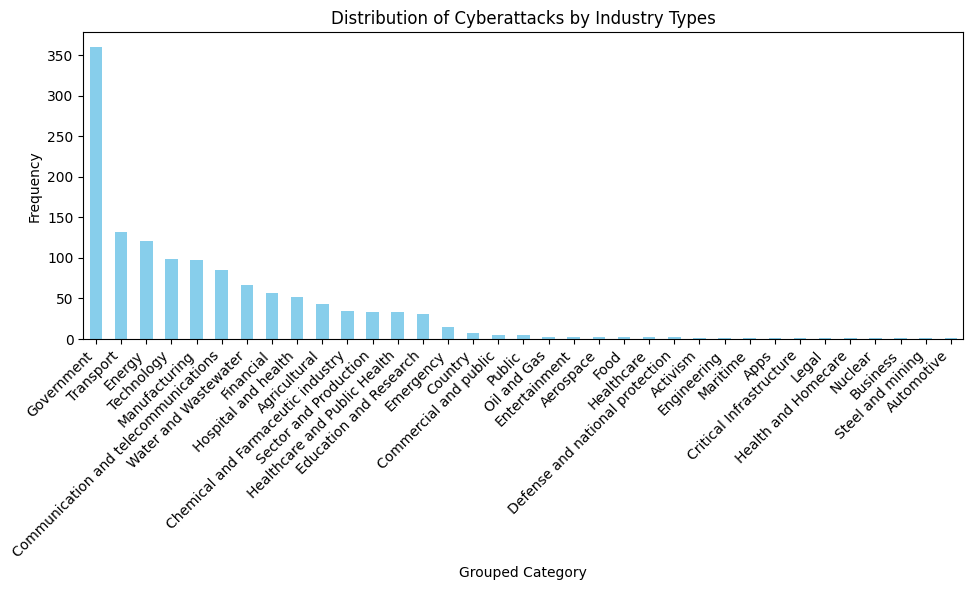

In [ ]:
# Histograma 'subcategory'
plt.figure(figsize=(10, 6))
df['industry_type'].value_counts().plot(kind='bar', color='skyblue')
plt.title('Distribution of Cyberattacks by Industry Types')
plt.xlabel('Grouped Category')
plt.ylabel('Frequency')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

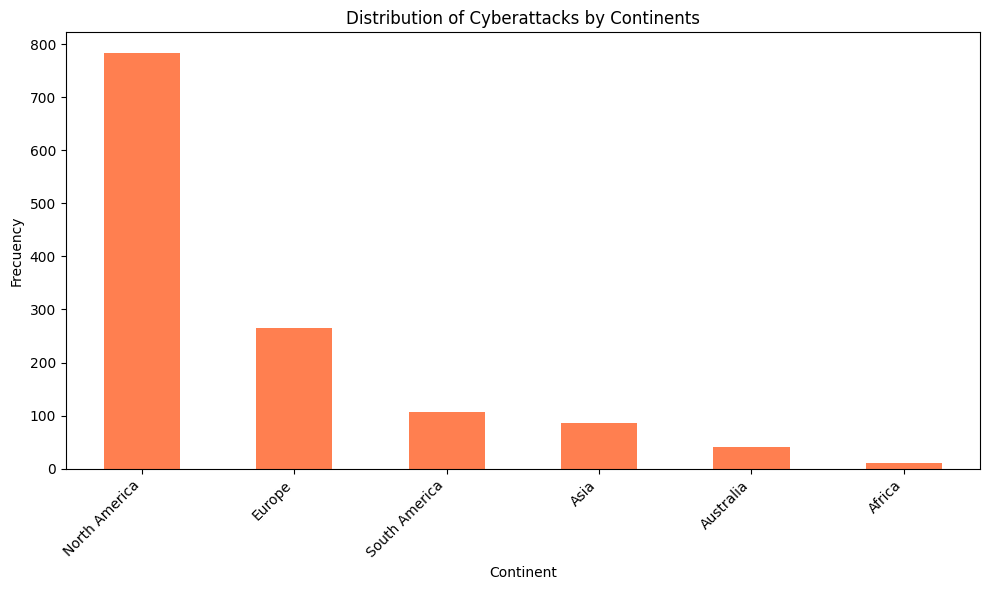

In [ ]:
# Crear un histograma de la columna 'continent'
plt.figure(figsize=(10, 6))
df['continent'].value_counts().plot(kind='bar', color='coral')
plt.title('Distribution of Cyberattacks by Continents')
plt.xlabel('Continent')
plt.ylabel('Frecuency')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()